In [80]:
from bs4 import BeautifulSoup
import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

# Loading and Cleaning Data

## Loading Datasets

In [14]:
historical_df = pd.read_csv("./concat_coinmarketcap_historical_new.csv")
todays_price_df = pd.read_csv("./coinmarketcap_current_price.csv")

In [43]:
todays_price_df["Name|Symbol"] = todays_price_df["Name"] + "|" + todays_price_df["Symbol"]
# todays_crypto_to_price = dict()
# for _, row  in todays_price_df[["Name|Symbol", "Price"]].iterrows():
#     crypto, price = row.values
#     try:
#         todays_crypto_to_price[crypto] = float(price[1:].replace(",", ""))
#     except:
#         pass

In [4]:
# creating unique identifier by concatenating name and symbol togehther
historical_df["Name|Symbol"] = historical_df["Name"] + "|" + historical_df["Symbol"]

In [5]:
# creating date object from string date
historical_df["date"] = pd.to_datetime(historical_df["date"]).apply(lambda x: x.date())

In [6]:
# looking at missing dates in my dataframe
last_date = datetime.date(2013, 4, 27)
for d in historical_df.date.unique():
    if (d - last_date).days > 1:
        print(d, last_date)
    last_date = d

2014-11-15 2014-11-13
2015-09-18 2015-09-16
2016-03-11 2016-03-09
2016-05-12 2016-05-10
2016-07-04 2016-07-02
2017-07-30 2017-07-28
2018-06-16 2018-06-14
2018-12-22 2018-12-20
2020-11-02 2020-10-31
2020-11-17 2020-11-15
2020-12-02 2020-11-30


## Deduplicating Datafame

In [7]:
# figuring out if we have any duplicate entries
groupby_df = historical_df.drop_duplicates().groupby(["Name|Symbol", "date"])["market_cap"].count()
groupby_df.loc[groupby_df > 1]

Name|Symbol  date      
Elrond|EGLD  2020-09-04    2
Name: market_cap, dtype: int64

In [9]:
# checking index for the duplicates
dedup_df = historical_df[["Name|Symbol", "date", "market_cap", "price"]].drop_duplicates()
filt_df = dedup_df.loc[dedup_df["Name|Symbol"] == "Elrond|EGLD"]
filt_df.loc[filt_df["date"] == datetime.date(2020, 9, 4)]

In [12]:
# deduplicating dataframe manually and automatically
dedup_historical_df = historical_df[["Name|Symbol", "date", "market_cap", "price"]].drop_duplicates().drop(489230)

In [13]:
market_cap_df = dedup_historical_df.pivot(values="market_cap", index="date", columns="Name|Symbol")
price_df = dedup_historical_df.pivot(values="price", index="date", columns="Name|Symbol")

# Running Investment Scenario

In [34]:
# https://zhiyzuo.github.io/Plot-Lorenz/
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

In [178]:
def run_scenarios_for_start_date(start_date):
    treasury = 0
    BUY_AMOUNT = 1000
    MIN_MARKET_CAP = 1000
    bag_df = pd.DataFrame({"units": [], "price_bought": [], "date_bought": [],
                           "sold_half": [], "date_sold_half": []})
    min_treasury = 0
    filt_market_cap_df = market_cap_df.loc[start_date:]
    btc_price_day_0 = price_df.loc[start_date, "Bitcoin|BTC"]
    eth_price_day_0 = price_df.loc[start_date, "Ethereum|ETH"]
    for day in filt_market_cap_df.index:
        market_cap_for_day = filt_market_cap_df.loc[day]
        qualifying_cryptos = market_cap_for_day.loc[market_cap_for_day >= MIN_MARKET_CAP].index
        # Checking to see if there are any new cryptos we need to buy
        for crypto in qualifying_cryptos:
            price = price_df.loc[day, crypto]
            if crypto not in bag_df.index and price != 0:
                units = BUY_AMOUNT / price
                treasury -= BUY_AMOUNT
                bag_df.loc[crypto, "units"] = units
                bag_df.loc[crypto, "price_bought"] = price
                bag_df.loc[crypto, "sold_half"] = False
                bag_df.loc[crypto, "date_bought"] = day
    #             print((crypto, price, units))
        # Checking to see if we should take profit from any of our cryptos
        for crypto in bag_df.loc[~bag_df["sold_half"]].index:
            current_price = price_df.loc[day, crypto]
            if current_price >= 2 * bag_df.loc[crypto, "price_bought"]:
                # sell half of our crypto
                treasury += bag_df.loc[crypto, "units"] * current_price  / 2
                bag_df.loc[crypto, "units"] *= 0.5
                bag_df.loc[crypto, "sold_half"] = True
                bag_df.loc[crypto, "date_sold_half"] = day
    #     print((day, treasury))
        if pd.isnull(treasury):
            print("something went wrong")
            break
        min_treasury = min(treasury, min_treasury)
    
    btc_price_today = todays_price_df.query('Name == "Bitcoin"')["price"].values[0]
    eth_price_today = todays_price_df.query('Name == "Ethereum"')["price"].values[0]
    bag_with_todays_price_df = bag_df.reset_index().merge(todays_price_df,
                                                      left_on="index",
                                                      right_on="Name|Symbol",
                                                      how="left",
                                                      suffixes=("", "_today"))
    bag_with_todays_price_df["value"] = bag_with_todays_price_df["units"] * bag_with_todays_price_df["price"]
    bag_with_todays_price_df["no_sell_value"] = (1 + bag_with_todays_price_df["sold_half"]) * bag_with_todays_price_df["value"]

    gini_sell_half = gini(np.array([v for v in bag_with_todays_price_df["value"].values if pd.notnull(v)]))
    gini_no_sell = gini(np.array([v for v in bag_with_todays_price_df["no_sell_value"].values if pd.notnull(v)]))
    min_treasury_sell_half = min_treasury
    min_treasury_no_sell = -bag_df.shape[0] * BUY_AMOUNT 
    bag_value_no_sell = bag_with_todays_price_df["no_sell_value"].sum()
    bag_value_sell_half = bag_with_todays_price_df["value"].sum()
    
    return bag_df, {
            "gini_no_sell": gini_no_sell,
            "gini_sell_half": gini_sell_half,
            "min_treasury_no_sell": min_treasury_no_sell,
            "min_treasury_sell_half": min_treasury_sell_half,
            "treasury_sell_half": treasury,
            "bag_value_no_sell": bag_value_no_sell,
            "bag_value_sell_half": bag_value_sell_half,
            "btc_price_day_0": btc_price_day_0,
            "btc_price_today": btc_price_today,
            "eth_price_day_0": eth_price_day_0,
            "eth_price_today": eth_price_today,
            "roi_eth": eth_price_today / eth_price_day_0,
            "roi_btc": btc_price_today / btc_price_day_0,
            "roi_sell_half": (treasury + bag_value_sell_half) / -min_treasury_sell_half,
            "roi_no_sell": bag_value_no_sell / -min_treasury_no_sell
            }

In [60]:
_, results = run_scenarios_for_start_date(datetime.date(2021, 1, 1))

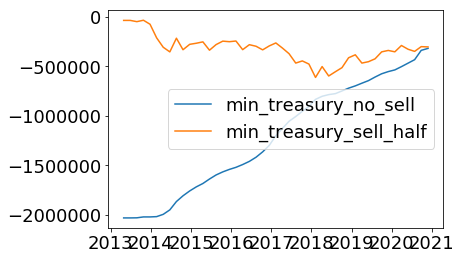

In [241]:
results_df.plot(y=["min_treasury_no_sell", "min_treasury_sell_half"])

In [86]:
# take every thirtieth date
date_to_results = dict()
for date_counter, d in enumerate(price_df.index):
    if date_counter % 60 == 0:
        print(date_counter, d)
        _, results = run_scenarios_for_start_date(d)
        date_to_results[d] = results

0 2013-04-28
60 2013-06-27
120 2013-08-26
180 2013-10-25
240 2013-12-24
300 2014-02-22
360 2014-04-23
420 2014-06-22
480 2014-08-21
540 2014-10-20
600 2014-12-20
660 2015-02-18
720 2015-04-19
780 2015-06-18
840 2015-08-17
900 2015-10-17
960 2015-12-16
1020 2016-02-14
1080 2016-04-15
1140 2016-06-15
1200 2016-08-15
1260 2016-10-14
1320 2016-12-13
1380 2017-02-11
1440 2017-04-12
1500 2017-06-11
1560 2017-08-11
1620 2017-10-10
1680 2017-12-09
1740 2018-02-07
1800 2018-04-08
1860 2018-06-07
1920 2018-08-07
1980 2018-10-06
2040 2018-12-05
2100 2019-02-04
2160 2019-04-05
2220 2019-06-04
2280 2019-08-03
2340 2019-10-02
2400 2019-12-01
2460 2020-01-30
2520 2020-03-30
2580 2020-05-29
2640 2020-07-28
2700 2020-09-26
2760 2020-11-27


In [90]:
results_df = pd.DataFrame(date_to_results).transpose()

In [230]:
results_df["roi_sell_half_new"] = -(results_df["treasury_sell_half"] - results_df["min_treasury_sell_half"]
 + results_df["bag_value_sell_half"]) / results_df["min_treasury_sell_half"]

In [103]:
results_df.to_csv("./summary_stats_df.csv", index=False)

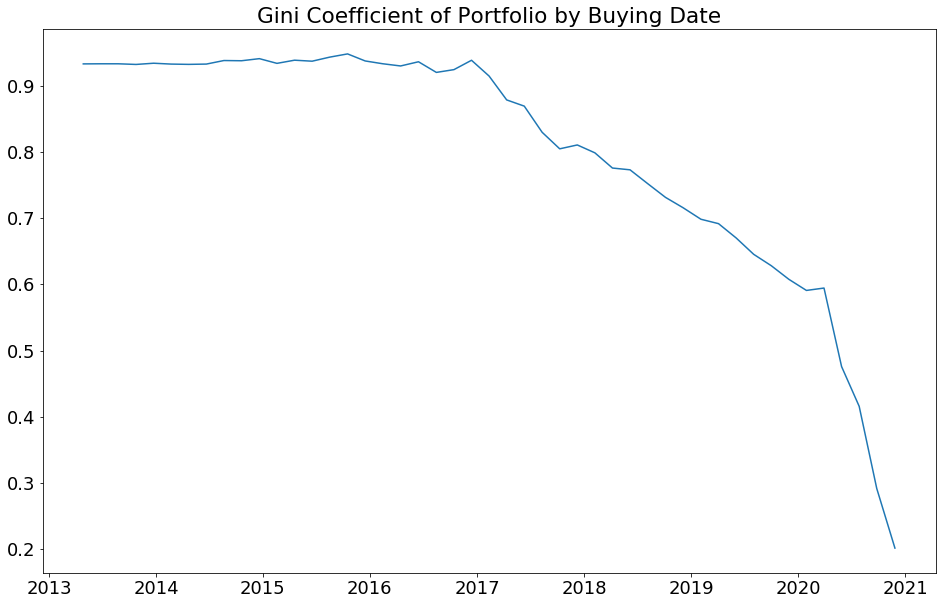

In [235]:
results_df.plot(y="gini_no_sell", legend=False, title="Gini Coefficient of Portfolio by Buying Date")
plt.gcf().set_size_inches(16, 10)

In [147]:
bitcoin_df = pd.read_csv("./bitcoinity_data.csv", names=["Time", "btc_market_cap"], header=0)
bitcoin_df["datetime"] = pd.to_datetime(bitcoin_df["Time"])
bitcoin_df["date"] = bitcoin_df["datetime"].apply(lambda x: x.date())
bitcoin_df.set_index("date", inplace=True)

In [117]:
all_currencies_df = pd.read_csv("./all_currencies.csv")

In [124]:
all_currencies_df["date"] = pd.to_datetime(all_currencies_df["Date"]).apply(lambda x: x.date())

In [128]:
all_currencies_df["date"].max()

datetime.date(2018, 9, 27)

In [110]:
random_coins = np.random.choice(price_df.columns, 100)

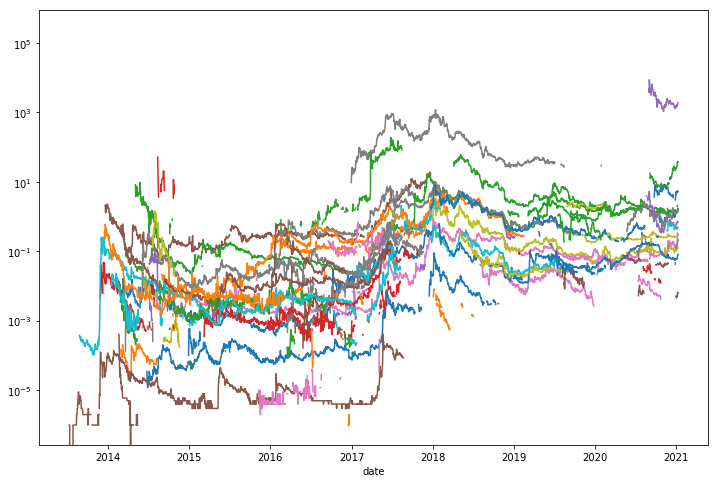

In [116]:
price_df[random_coins].plot(legend=False)
plt.gcf().set_size_inches(12, 8)
plt.yscale("log")

In [148]:
results_df["btc_market_cap"] = bitcoin_df["btc_market_cap"]

In [157]:
BUBBLE_PEAK_DATE = datetime.date(2017, 12, 17)

In [208]:
results_df["ROI ETH"] = (results_df["roi_eth"] - 1) * 100
results_df["ROI BTC"] = (results_df["roi_btc"] - 1) * 100
results_df["ROI HODL Strat"] = (results_df["roi_no_sell"] - 1) * 100
results_df["ROI Sell Half Strat"] = (results_df["roi_sell_half"] - 1) * 100

In [239]:
print(results_df.index.min())
print(results_df.index.max())

2013-04-28
2020-11-27


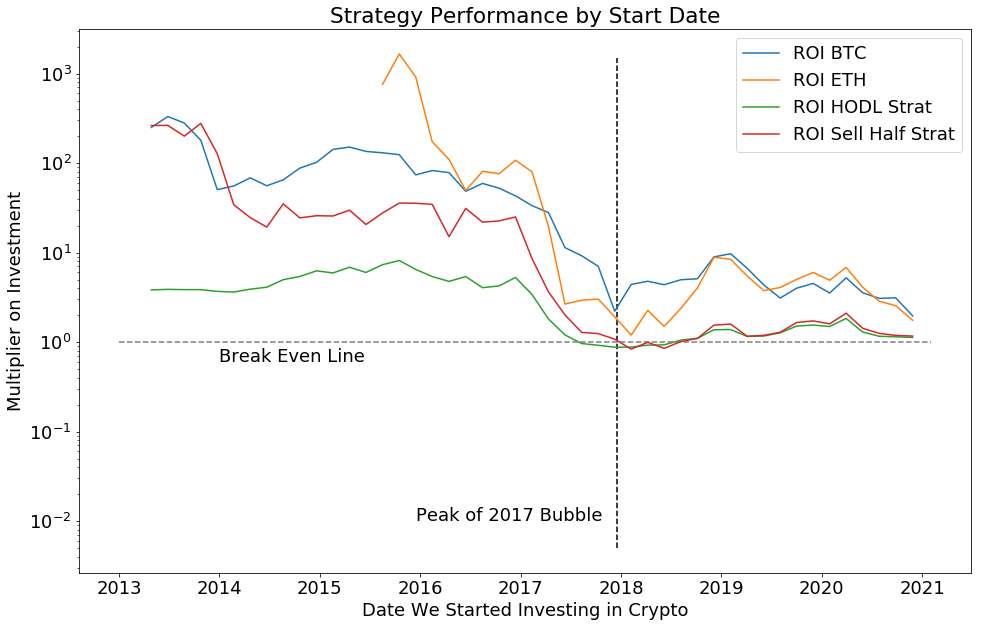

In [243]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots()
ax.hlines(xmin=datetime.date(2013, 1, 1), xmax=datetime.date(2021, 2, 1), y=1,
          linestyles="dashed", color="gray")
ax.vlines(ymin=0.005, ymax=1.5e3, x=BUBBLE_PEAK_DATE, linestyles="dashed")
# results_df.plot(y=["ROI BTC", "ROI ETH", "ROI HODL Strat", "ROI Sell Half Strat"],
results_df.plot(y=["roi_btc", "roi_eth", "roi_no_sell", "roi_sell_half_new"],
                ax=ax, title="Strategy Performance by Start Date")
plt.ylabel("Multiplier on Investment")
plt.xlabel("Date We Started Investing in Crypto")
plt.yscale("log")
ax.legend(["ROI BTC", "ROI ETH", "ROI HODL Strat", "ROI Sell Half Strat"])
ax.text(s="Break Even Line", x=datetime.date(2014, 1, 1), y=0.6, color="black")
ax.text(s="Peak of 2017 Bubble", x=BUBBLE_PEAK_DATE - datetime.timedelta(days=730),
        y=1e-2, color="black")
plt.gcf().set_size_inches(16, 10)

In [ ]:
one_month_intervals = datetime.date()

In [61]:
results

{'gini_no_sell': 0.07035750439890531,
 'gini_sell_half': 0.08219294246240283,
 'min_treasury_no_sell': -214000,
 'min_treasury_sell_half': -207950.02674192336,
 'treasury_sell_half': -205923.02602278529,
 'bag_value_no_sell': 218263.6068680208,
 'bag_value_sell_half': 214495.81876472005,
 'btc_price_day_0': 29374.15,
 'btc_price_today': 33605.48,
 'eth_price_day_0': 730.37,
 'eth_price_today': 907.11,
 'roi_eth': 1.2419869381272506,
 'roi_btc': 1.1440494448349996,
 'roi_sell_half': 0.04122525433754353,
 'roi_no_sell': 1.0199233965795365}

In [103]:
bag_df["datetime_bought"] = pd.to_datetime(bag_df["date_bought"])
bag_df["datetime_sold_half"] = pd.to_datetime(bag_df["date_sold_half"])

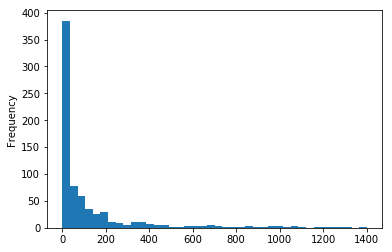

In [104]:
((bag_df["datetime_sold_half"] - bag_df["datetime_bought"]) / datetime.timedelta(days=1)).plot(kind="hist", bins=40)

In [113]:
treasury

3314529.9621666227

In [114]:
min_treasury

-34598.51889859373

In [140]:
bag_with_todays_price_df = bag_df.reset_index().merge(todays_price_df,
                                                      left_on="index",
                                                      right_on="Name|Symbol",
                                                      how="left",
                                                      suffixes=("", "_today"))

In [150]:
treasury + todays_value

6083391.466760616

In [151]:
min_treasury

-34598.51889859373

In [ ]:
bag_with_todays_price_df["loss"] = 

In [143]:
crypto_bag_descr_df = bag_with_todays_price_df.loc[pd.notnull(bag_with_todays_price_df["no_sell_value"])][["units", "no_sell_value", "Name", "date_bought"]].sort_values("no_sell_value", ascending=False)
crypto_bag_descr_df["cumul_value"] = crypto_bag_descr_df["no_sell_value"].cumsum()
crypto_bag_descr_df["pct_value"] = crypto_bag_descr_df["cumul_value"] / crypto_bag_descr_df["no_sell_value"].sum()

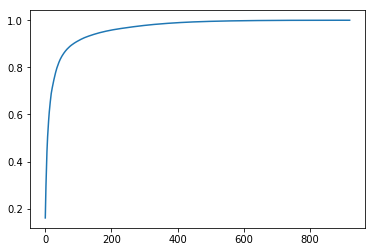

In [144]:
(crypto_bag_descr_df["pct_value"].reset_index()["pct_value"]).plot()

In [123]:
crypto_bag_descr_df["no_sell_loss"] = crypto_bag_descr_df["no_sell_value"] - BUY_AMOUNT

In [126]:
crypto_bag_descr_df["no_sell_loss"].describe()

count       921.000000
mean       4730.345884
std       37882.125713
min       -1000.000000
25%        -952.916510
50%        -732.522535
75%         105.078809
max      848301.652893
Name: no_sell_loss, dtype: float64

In [130]:
investment = crypto_bag_descr_df.shape[0] * BUY_AMOUNT

In [131]:
current_value = crypto_bag_descr_df["no_sell_value"].sum()

In [136]:
current_value / investment

5.7303458837178995

In [157]:
bag_with_todays_price_df["value"].sum()

2768861.504593993

In [158]:
treasury

3314529.9621666227

In [159]:
min_treasury

-34598.51889859373